<a href="https://www.kaggle.com/code/andrewdiachkov/lungscheck?scriptVersionId=155166140" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

import random     
from collections import Counter
import cv2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load dataset
dataset = r'/kaggle/input/chest-xray-pneumonia/chest_xray/train'
categories = ['NORMAL', 'PNEUMONIA'] # names of the folders

In [3]:
img_size = 256 # to resize an image

In [4]:
#Process images for CNN
def imgProcessing(directory,categories):   
    data = []
    for i in categories:
        path = os.path.join(directory, i)
        class_num = categories.index(i)
        for file in os.listdir(path):
            filepath = os.path.join(path, file)
            img = cv2.imread(filepath, 0)
            img = cv2.GaussianBlur(img, (5, 5), 0)  # apply GaussianBlur filter to reduce the noise
            img = cv2.resize(img, (img_size, img_size))# resise images to the size 256 x 256 
            data.append([img, class_num])    # create a list of matches images and categories
    random.shuffle(data)     # shaffle the categories in the list
    X, y = [], []
    for feature, label in data:     
        X.append(feature)
        y.append(label)
    print('Number of images:', len(X))
    print('Classes:', Counter(y)) # create a dictionary that stores labels as keys and their counts as values
    X = np.array(X).reshape(-1, img_size, img_size, 1) # reshape an array
    X = X / 255.0   # data normalization for CNN
    y = np.array(y)
    return X, y

In [5]:
X,y = imgProcessing(dataset, categories)

Number of images: 5216
Classes: Counter({1: 3875, 0: 1341})


In [6]:
print(len(X),X.shape, y.shape)

5216 (5216, 256, 256, 1) (5216,)


In [7]:
# Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y) 
print(Counter(y_train), Counter(y_test))

Counter({1: 2906, 0: 1006}) Counter({1: 969, 0: 335})


In [8]:
X_train.shape

(3912, 256, 256, 1)

In [9]:
# Apply SMOTE
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1) #reshape to 2D for SMOTE
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

#X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)  #reshape back
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)
print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

Before SMOTE: Counter({1: 2906, 0: 1006})
After SMOTE: Counter({1: 2906, 0: 2906})
3912 (3912, 65536)
5812 (5812, 256, 256, 1)


In [10]:
# CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train_sampled.shape[1:])))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout layer for regularization

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [12]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(X_train_sampled, y_train_sampled, batch_size=100, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
59/59 [==============================] - 23s 195ms/step - loss: 0.5255 - accuracy: 0.7983 - val_loss: 0.3472 - val_accuracy: 0.8681
Epoch 2/10
59/59 [==============================] - 10s 162ms/step - loss: 0.1511 - accuracy: 0.9465 - val_loss: 0.1371 - val_accuracy: 0.9502
Epoch 3/10
59/59 [==============================] - 10s 163ms/step - loss: 0.0891 - accuracy: 0.9685 - val_loss: 0.0866 - val_accuracy: 0.9678
Epoch 4/10
59/59 [==============================] - 10s 164ms/step - loss: 0.0646 - accuracy: 0.9752 - val_loss: 0.0856 - val_accuracy: 0.9686
Epoch 5/10
59/59 [==============================] - 10s 165ms/step - loss: 0.0556 - accuracy: 0.9809 - val_loss: 0.0874 - val_accuracy: 0.9709
Epoch 6/10
59/59 [==============================] - 10s 165ms/step - loss: 0.0561 - accuracy: 0.9794 - val_loss: 0.1036 - val_accuracy: 0.9647
Epoch 7/10
59/59 [==============================] - 10s 167ms/step - loss: 0.0364 - accuracy: 0.9866 - val_loss: 0.0880 - val_accuracy: 0.9724

In [14]:
# Accuracy and Loss visualization
def Visualization(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

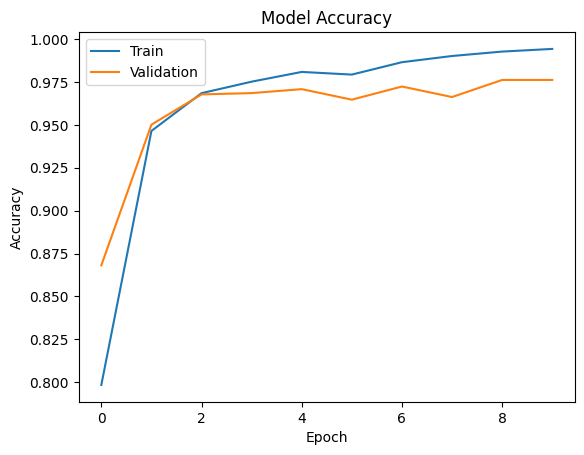

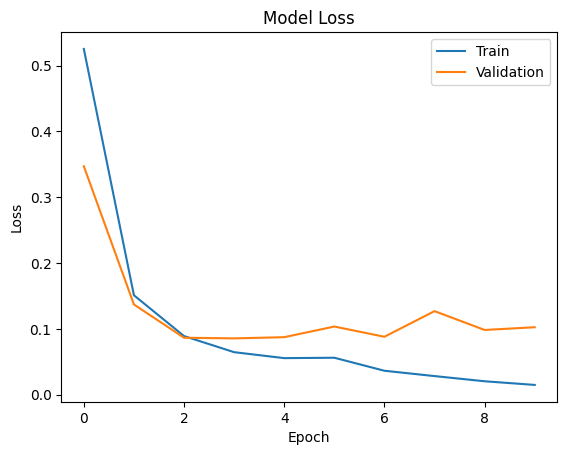

In [15]:
 Visualization(history)

In [16]:
# Use model.evaluate to get the loss and metrics values
loss, accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

41/41 [==============================] - 1s 24ms/step - loss: 0.1025 - accuracy: 0.9762
Test Loss: 0.10249783843755722
Test Accuracy: 0.9762269854545593


In [17]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary classes

41/41 [==============================] - 1s 14ms/step


In [18]:
#with np.printoptions(threshold=np.inf): # full array for the last image above
#    print(np.round(y_pred_prob,3).reshape(-1))

In [19]:
# Additional metrics for binary classification
accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1score = f1_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
classification_rep = classification_report(y_test, y_pred_classes)

print(f"Accuracy: {accuracy.round(2)}")
print(f"Recall: {recall.round(2)}")
print(f"Precision: {precision.round(2)}")
print(f"f1_score: {f1score.round(2)}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.98
Recall: 0.98
Precision: 0.98
f1_score: 0.98
Confusion Matrix:
[[319  16]
 [ 15 954]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       335
           1       0.98      0.98      0.98       969

    accuracy                           0.98      1304
   macro avg       0.97      0.97      0.97      1304
weighted avg       0.98      0.98      0.98      1304



In [20]:
#test classes
def imgOutput(number):
    single_image = X_test[number]
    plt.imshow(single_image.reshape(256, 256), cmap=plt.cm.gray)
    plt.show()
    print('actual category:', y_test[number])
    print('predicted category:', y_pred_classes[number])

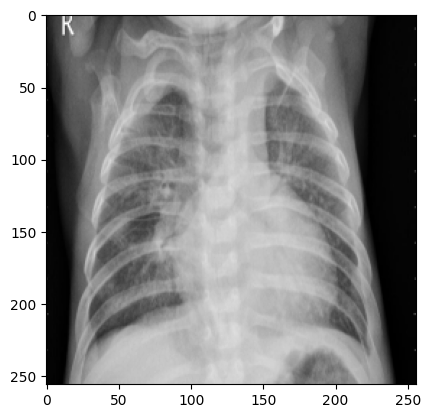

actual category: 1
predicted category: [1]


In [21]:
imgOutput(155)

In [22]:
# save the model
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
